In [1]:
# EDA and Training Notebook for Pneumonia Detection

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub


2025-06-05 01:54:18.867347: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 01:54:20.658838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 01:54:20.659160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 01:54:20.954439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 01:54:21.683072: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 01:54:21.687461: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:

# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [3]:

# Download and access dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_dir = os.path.join(path, "chest_xray")

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")



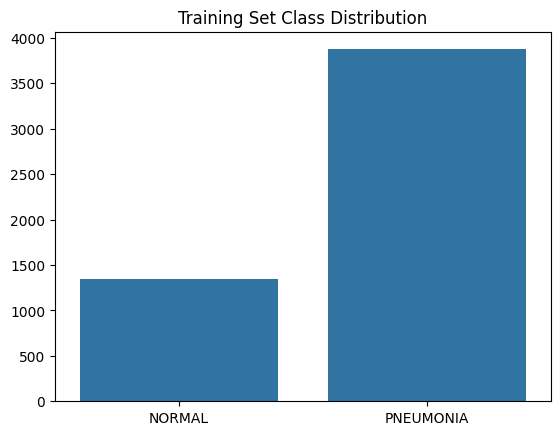

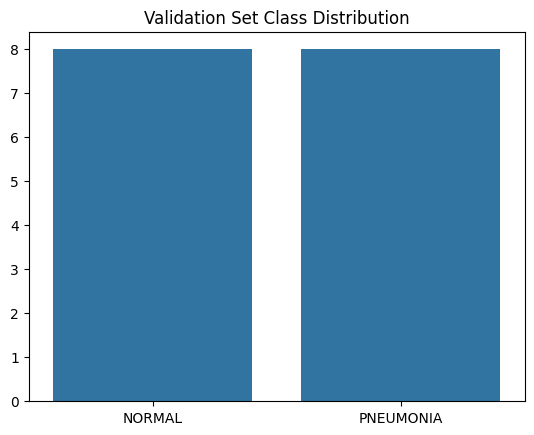

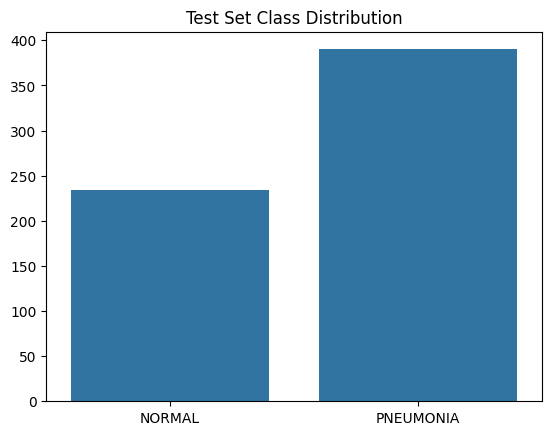

In [4]:
# Plot class distribution
def plot_class_distribution(directory, title):
    classes = ['NORMAL', 'PNEUMONIA']
    counts = [len(os.listdir(os.path.join(directory, cls))) for cls in classes]
    sns.barplot(x=classes, y=counts)
    plt.title(title)
    plt.show()

plot_class_distribution(train_dir, "Training Set Class Distribution")
plot_class_distribution(val_dir, "Validation Set Class Distribution")
plot_class_distribution(test_dir, "Test Set Class Distribution")



In [5]:
# Data Generators
img_size = (224, 224)
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_gen = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_gen = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i : class_weights[i] for i in range(2)}


In [7]:

# Build Model using MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [8]:

# Train Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model/pneumonia_mobilenetv2.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks
)



2025-06-05 01:55:17.606253: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


Epoch 1/20


2025-06-05 01:55:29.147851: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-05 01:55:29.172112: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-05 01:55:29.705525: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-05 01:55:29.842706: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


163/163 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8729

/media/hunter/MYdrive/guvi/pneumonia_detection_cnn/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 338s 2s/step - loss: 0.2853 - accuracy: 0.8729 - val_loss: 0.3306 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - 292s 2s/step - loss: 0.1860 - accuracy: 0.9181 - val_loss: 0.2319 - val_accuracy: 0.8750
Epoch 3/20
163/163 [==============================] - 255s 2s/step - loss: 0.1787 - accuracy: 0.9241 - val_loss: 0.2967 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 250s 2s/step - loss: 0.1639 - accuracy: 0.9331 - val_loss: 0.2328 - val_accuracy: 0.8750
Epoch 5/20
163/163 [==============================] - 265s 2s/step - loss: 0.1579 - accuracy: 0.9410 - val_loss: 0.3635 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 255s 2s/step - loss: 0.1520 - accuracy: 0.9369 - val_loss: 0.2673 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 228s 1s/step - loss: 0.1587 - accuracy: 0.9340 - val_loss: 0.5164 - val_accuracy: 0.8125


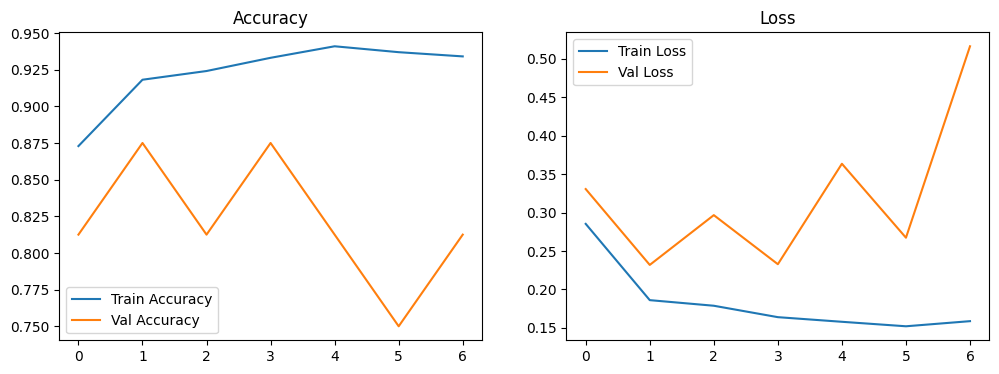

In [10]:
# Plot Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [9]:

# Evaluate Model
preds = model.predict(test_gen)
preds = (preds > 0.5).astype(int)

print(confusion_matrix(test_gen.classes, preds))
print(classification_report(test_gen.classes, preds, target_names=['NORMAL', 'PNEUMONIA']))


20/20 [==============================] - 28s 1s/step
[[209  25]
 [ 43 347]]
              precision    recall  f1-score   support

      NORMAL       0.83      0.89      0.86       234
   PNEUMONIA       0.93      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624

